# Libraries

In [ ]:
import xarray as xr
from datetime import datetime

import torch

from aurora import AuroraSmall, Batch, Metadata, rollout
import matplotlib.pyplot as plt

from pathlib import Path

import cdsapi
import numpy as np
from sklearn.metrics import root_mean_squared_error

# Manage memories issues

In [2]:

torch.cuda.empty_cache()
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"

# Downloading the Data

pip uninstall torch torchvision torchaudio
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [3]:
# !pip install cdsapi
# !pip install torch
# import os
# # os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# # os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"

In [2]:


# Data will be downloaded here.
download_path = Path("data")

c = cdsapi.Client()

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables.
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2023-01-01-surface-level.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "mean_sea_level_pressure",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-surface-level.nc"),
    )
print("Surface-level variables downloaded!")

# Download the atmospheric variables.
if not (download_path / "2023-01-01-atmospheric.nc").exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "temperature",
                "u_component_of_wind",
                "v_component_of_wind",
                "specific_humidity",
                "geopotential",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-atmospheric.nc"),
    )
print("Atmospheric variables downloaded!")

2025-02-23 10:33:32,602 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-23 10:33:32,604 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-23 10:33:32,862 INFO Request ID is 68a03206-5939-4011-a730-88e8149ba97e
2025-02-23 10:33:32,910 INFO status has been updated to accepted
2025-02-23 10:33:37,803 INFO status has been updated to running
2025-02-23 10:33:41,256 INFO status has been updated to successful


Static variables downloaded!


2025-02-23 10:33:42,028 INFO Request ID is cd53cd3f-b719-4850-b788-5c22bcee5dac
2025-02-23 10:33:42,064 INFO status has been updated to accepted
2025-02-23 10:33:50,395 INFO status has been updated to successful
2025-02-23 10:33:51,211 INFO Request ID is 0ee70af4-8bd6-46eb-a48d-854abfa1ae07          


Surface-level variables downloaded!


2025-02-23 10:33:51,299 INFO status has been updated to accepted
2025-02-23 10:34:23,826 INFO status has been updated to successful
                                                                                        

Atmospheric variables downloaded!


# Preparing a Batch

In [35]:
import torch
import xarray as xr
import aurora
from aurora import Batch, Metadata

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / "2023-01-01-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / "2023-01-01-atmospheric.nc", engine="netcdf4")

i = 1  # Select this time index in the downloaded data.

batch = Batch(
    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[[i - 1, i]][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[[i - 1, i]][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[[i - 1, i]][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[[i - 1, i]][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[[i - 1, i]][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[[i - 1, i]][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[[i - 1, i]][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[[i - 1, i]][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[[i - 1, i]][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

In [37]:
batch.metadata.time

(datetime.datetime(2023, 1, 1, 6, 0),)

# Loading and Running the Model

In [3]:
model = AuroraSmall()
model.load_state_dict(torch.load('../model/aurora.pth'))

NameError: name 'AuroraSmall' is not defined

## Make some predictions

In [6]:
model.eval()
model = model.to("cuda")

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

model = model.to("cpu")

In [9]:
batch.surf_vars["2t"][0, 0][:-1, :].shape

torch.Size([720, 1440])

In [10]:
preds[1].surf_vars["2t"].squeeze().shape

torch.Size([720, 1440])

In [13]:
preds[0].surf_vars["2t"][0, 0].numpy().shape

(720, 1440)

# Plot prediction

## Surface variables

# Temperature

In [34]:
batch.surf_vars["2t"]

tensor([[[[247.2171, 247.2171, 247.2171,  ..., 247.2171, 247.2171, 247.2171],
          [248.4847, 248.4866, 248.4905,  ..., 248.4788, 248.4808, 248.4827],
          [249.5120, 249.5159, 249.5198,  ..., 249.5003, 249.5042, 249.5081],
          ...,
          [249.4632, 249.4651, 249.4651,  ..., 249.4612, 249.4612, 249.4632],
          [249.1019, 249.1019, 249.1019,  ..., 249.0999, 249.1019, 249.1019],
          [248.3499, 248.3499, 248.3499,  ..., 248.3499, 248.3499, 248.3499]],

         [[247.2357, 247.2357, 247.2357,  ..., 247.2357, 247.2357, 247.2357],
          [248.5014, 248.5033, 248.5053,  ..., 248.4955, 248.4975, 248.4994],
          [249.4604, 249.4623, 249.4662,  ..., 249.4506, 249.4545, 249.4584],
          ...,
          [249.5229, 249.5209, 249.5209,  ..., 249.5209, 249.5229, 249.5229],
          [249.0229, 249.0229, 249.0229,  ..., 249.0209, 249.0229, 249.0229],
          [247.9857, 247.9857, 247.9857,  ..., 247.9857, 247.9857, 247.9857]]]])

In [28]:
surf_vars_ds["t2m"][0].valid_time

<xarray.DataArray 'valid_time' ()> Size: 8B
array('2023-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    number      int64 8B ...
    valid_time  datetime64[ns] 8B 2023-01-01
    expver      <U4 16B ...
Attributes:
    long_name:      time
    standard_name:  time

### Two-meter temperature in K: 2t

0
1


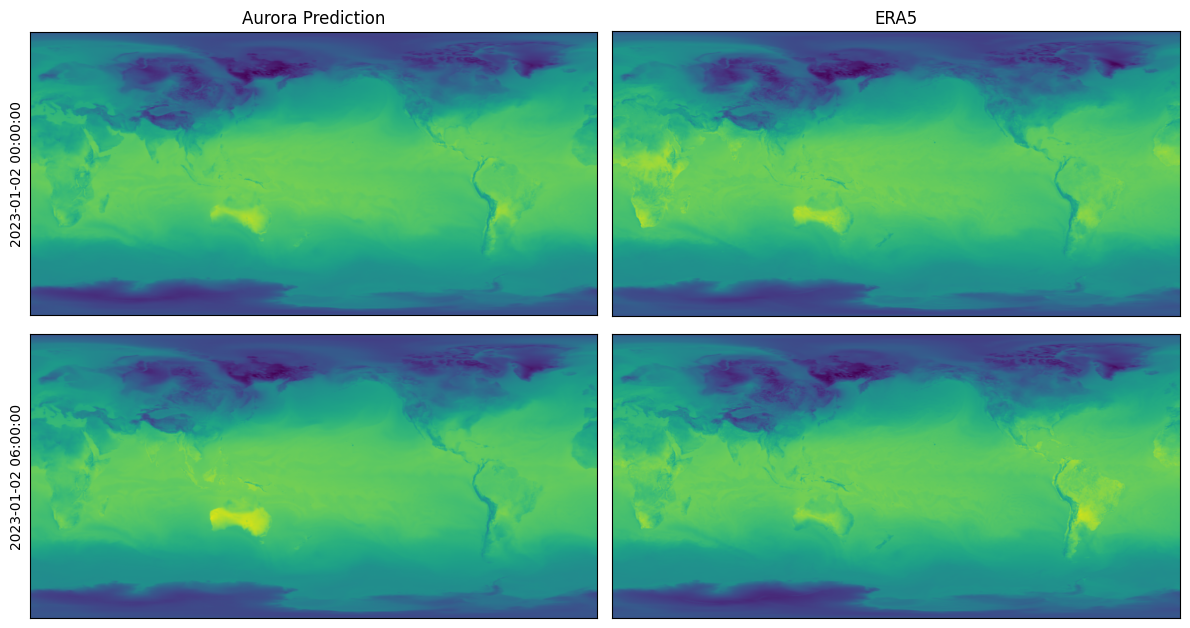

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(ax.shape[0]):
    print(i)
    pred = preds[i]

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ax[i, 1].imshow(surf_vars_ds["t2m"][2 + i].values - 273.15, vmin=-50, vmax=50)
    if i == 0:
        ax[i, 1].set_title("ERA5")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()

RMSE: 2.51755952835083
RMSE: 2.774423122406006


FileNotFoundError: [Errno 2] No such file or directory: 'aurora-prediction-world/aurora-prediction-t2m-world.pdf'

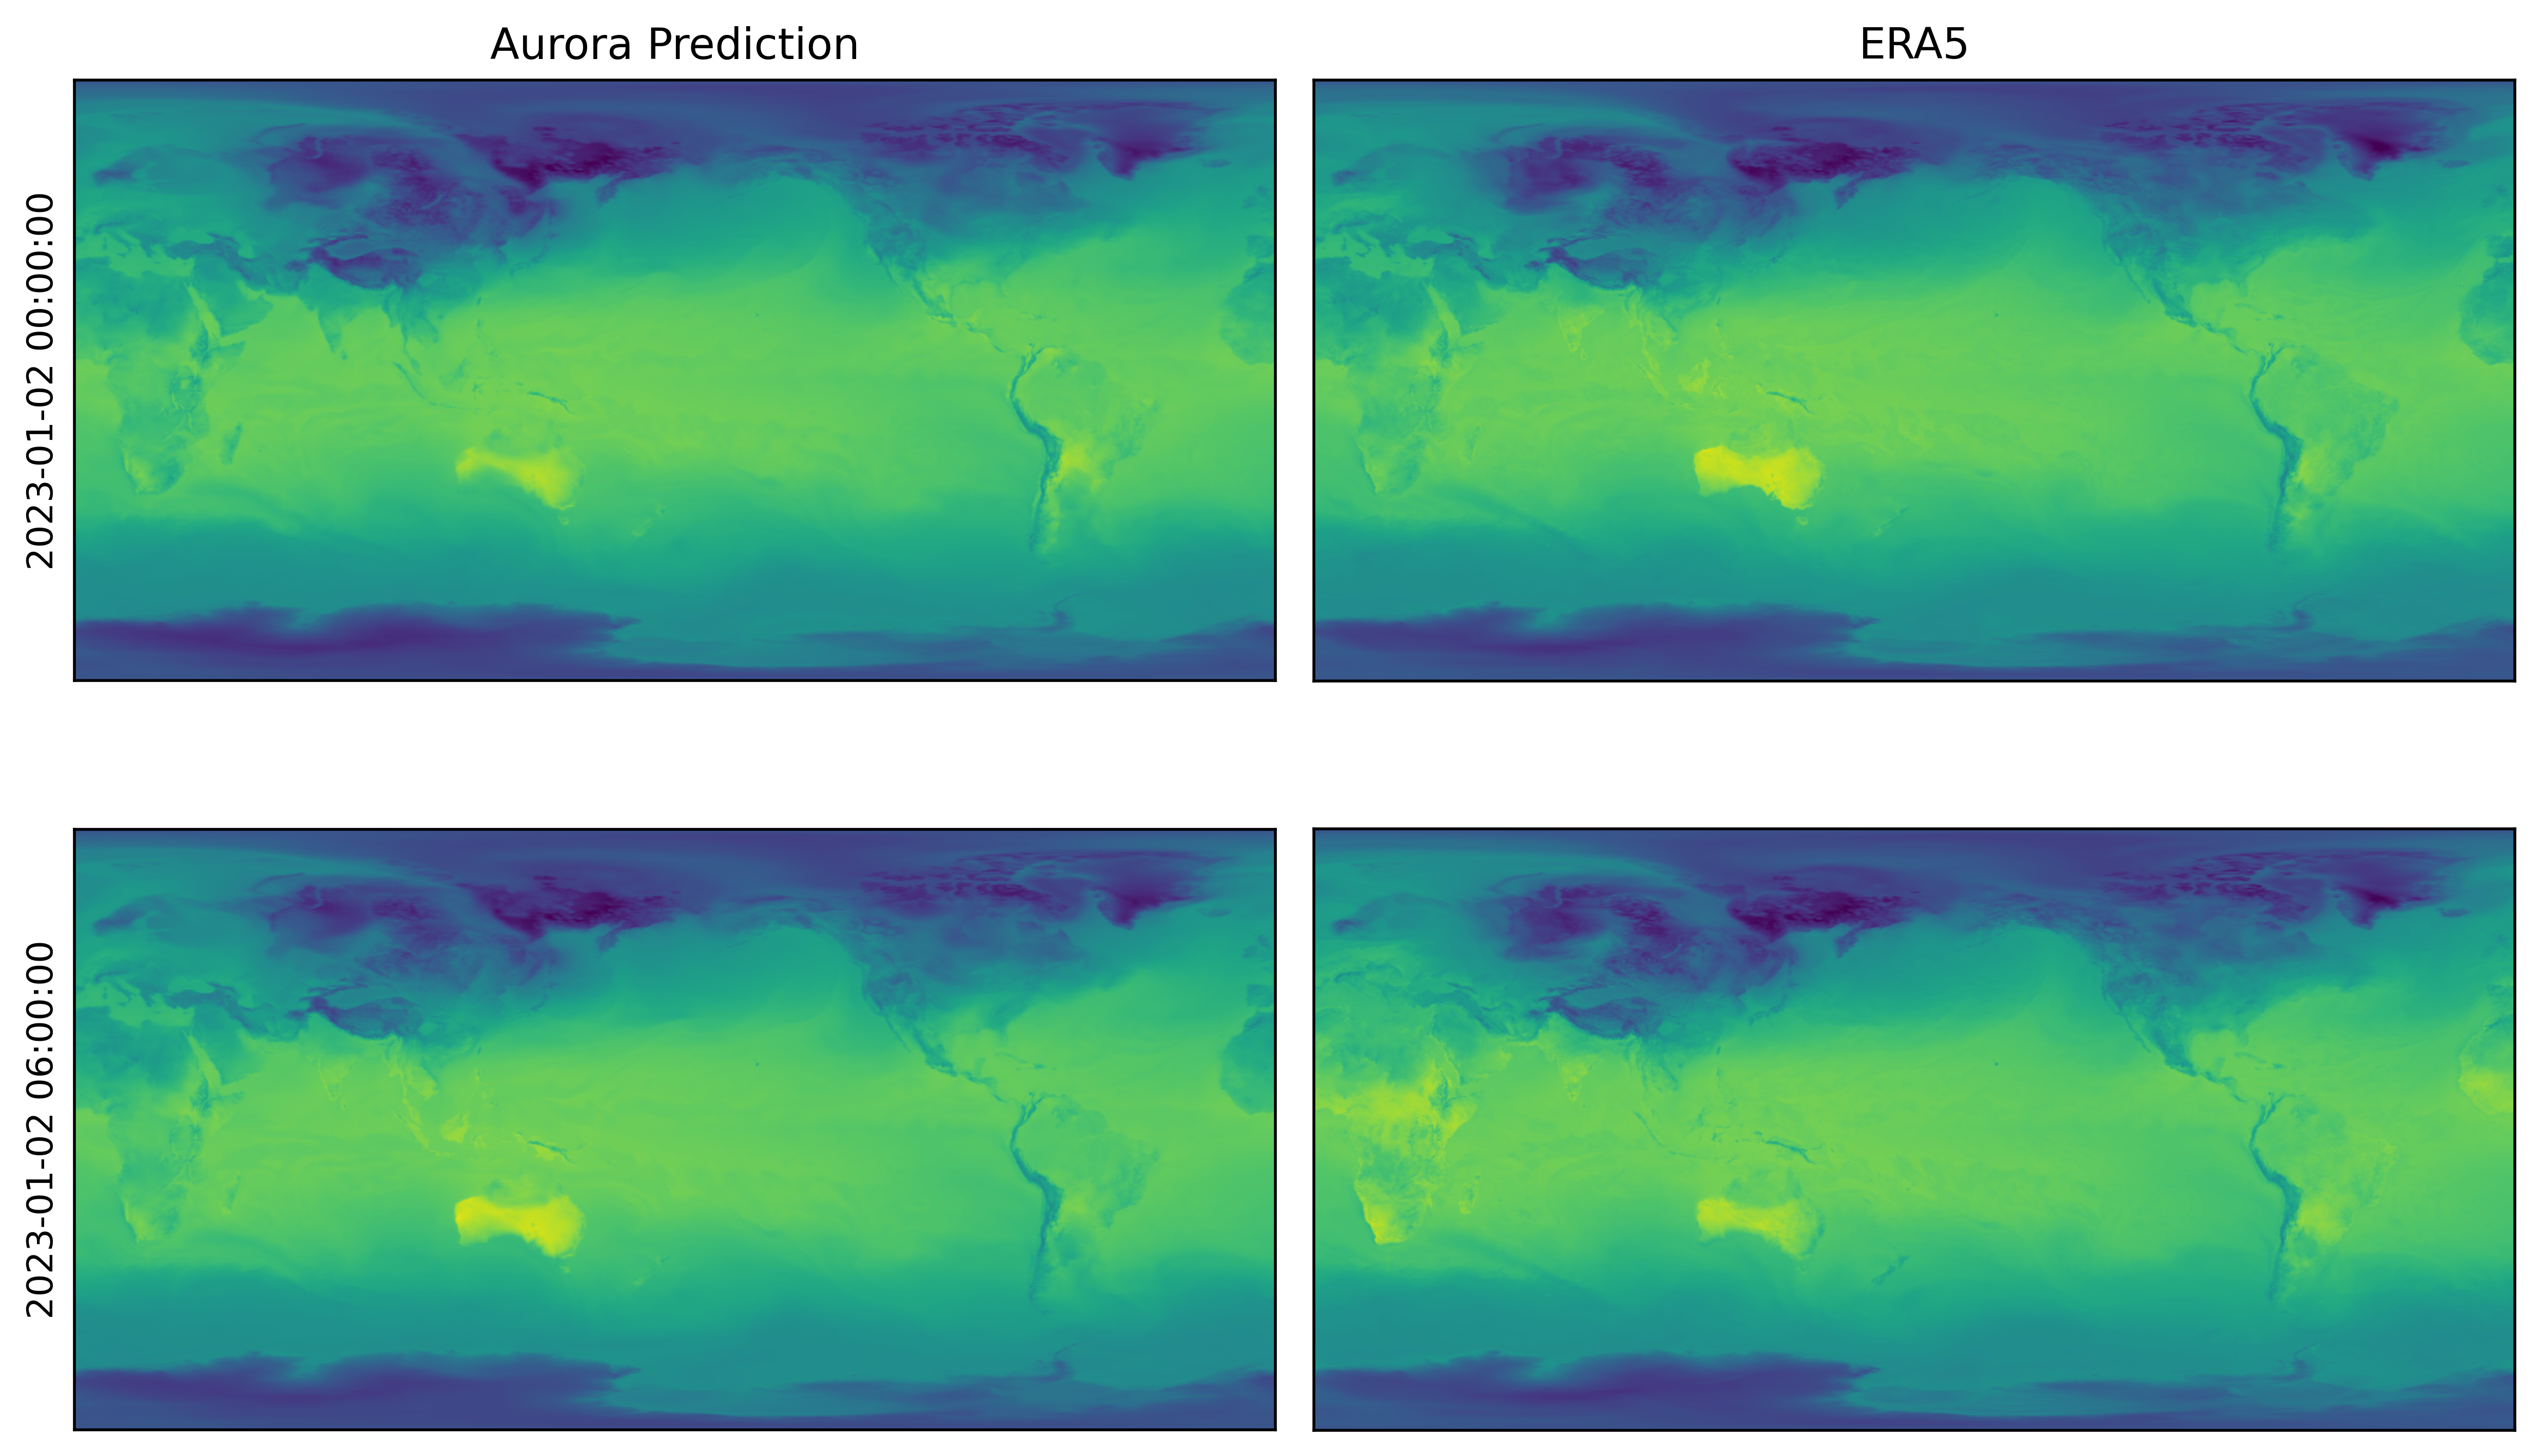

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6.5), dpi=500)

for i in range(ax.shape[0]):
    pred = preds[i] 
    prediction = pred.surf_vars["2t"][0, 0].numpy()
    actual = surf_vars_ds["t2m"][1 + i].values [:-1, :]
    rmse = root_mean_squared_error(actual.squeeze(), prediction.squeeze() )
    print(f"RMSE: {rmse}")

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ax[i, 1].imshow(surf_vars_ds["t2m"][1 + i].values - 273.15, vmin=-50, vmax=50)
    if i == 0:
        ax[i, 1].set_title("ERA5")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
plt.tight_layout()
plt.savefig("aurora-prediction-world/aurora-prediction-t2m-world.pdf")
plt.savefig("aurora-prediction-world/aurora-prediction-t2m-world.png")

### Ten-meter eastward wind speed in m/s :U10

In [29]:
def plot_predictions(predict_data, actual_data, var_type:str,
                     pred_var_name:str, actual_var_name:str, 
                     nrows:int=2, ncols:int=2,
                     figsize=(10, 6.5), atmos_level_idx=0, 
                     save_path="aurora-prediction-world"):


    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, dpi=500)

    for i in range(ax.shape[0]):
        pred = predict_data[i]
        if var_type=="surface":
            ax[i, 0].imshow(pred.surf_vars[pred_var_name][0, 0].numpy())
            prediction = pred.surf_vars[pred_var_name][0, 0].numpy()
            actual = actual_data[actual_var_name][1 + i].values
            print(prediction.shape, actual.shape)
        elif var_type=="atmosphere":
            ax[i, 0].imshow(pred.atmos_vars[actual_var_name].squeeze()[atmos_level_idx,:,:].numpy())
        elif var_type=="static":
            ax[i, 0].imshow(pred.static_vars[pred_var_name].numpy())
            
        ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
        if i == 0:
            ax[i, 0].set_title("Aurora Prediction")
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        if var_type=="atmosphere":
            ax[i, 1].imshow(actual_data[actual_var_name][i,atmos_level_idx,:,:].values)
        elif var_type=="static":
            ax[i, 1].imshow(actual_data[actual_var_name].squeeze().values)
        else:
            ax[i, 1].imshow(actual_data[actual_var_name][1 + i].values)
        if i == 0:
            ax[i, 1].set_title("ERA5")
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])

    plt.tight_layout()
    plt.savefig(f"{save_path}/aurora-prediction-{actual_var_name}-world.pdf")
    plt.savefig(f"{save_path}/aurora-prediction-{actual_var_name}-world.png")
    plt.show()

In [11]:
def compute_rmse(predict_data, actual_data, var_type:str,
                     pred_var_name:str, actual_var_name:str
                     , atmos_level_idx=0):


    for i in range(2):
        pred = predict_data[i]
        if var_type=="surface":
            prediction = pred.surf_vars[pred_var_name][0, 0].numpy()
            actual = actual_data[actual_var_name][1 + i].values[:-1, :]
            rmse = root_mean_squared_error(actual.squeeze(), prediction.squeeze() )
            print(f"RMSE: {rmse}")
        elif var_type=="atmosphere":
            prediction = pred.atmos_vars[actual_var_name].squeeze()[atmos_level_idx,:,:].numpy().squeeze()
            actual = actual_data[actual_var_name][i,atmos_level_idx,:,:].values[:-1,:]
            # print(prediction.shape, actual.shape)
            rmse = root_mean_squared_error(actual.squeeze(), prediction.squeeze() )
            print(f"RMSE: {rmse}")
        

In [41]:
surf_vars_ds['u10'].shape

(4, 721, 1440)

In [30]:
# def plot_predictions(predict_data, actual_data, var_type:str,
#                      pred_var_name:str, actual_var_name:str, 
#                      nrows:int=2, ncols:int=2,
#                      figsize=(10, 6.5), atmos_level_idx=0, 
#                      save_path="aurora-prediction-sa"):


#     fig, ax = plt.subplots(nrows, ncols, figsize=figsize, dpi=500)

#     for i in range(ax.shape[0]):
#         pred = predict_data[i]
#         if var_type=="surface":
#             ax[i, 0].imshow(pred.surf_vars[pred_var_name][0, 0].numpy())
#             actual = actual_data[actual_var_name][1 + i].values
#             prediction = pred.surf_vars[pred_var_name][0, 0].numpy()
#             print(actual.shape, prediction.shape)
#             print(f"RMSE: {root_mean_squared_error(actual.flatten(), prediction.flatten()) }")
            
#         elif var_type=="atmosphere":
#             ax[i, 0].imshow(pred.atmos_vars[actual_var_name].squeeze()[atmos_level_idx,:,:].numpy())
#             actual = actual_data[actual_var_name][i,atmos_level_idx,:,:].values
#             prediction = pred.atmos_vars[actual_var_name].squeeze()[atmos_level_idx,:,:]
#             # print(actual.shape, prediction.shape)
#             print(f"RMSE: {root_mean_squared_error(actual.flatten(), prediction.flatten()) }")
#         elif var_type=="static":
#             ax[i, 0].imshow(pred.static_vars[pred_var_name].numpy())
            
#         ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
#         if i == 0:
#             ax[i, 0].set_title("Aurora Prediction")
#         ax[i, 0].set_xticks([])
#         ax[i, 0].set_yticks([])
#         if var_type=="atmosphere":
#             ax[i, 1].imshow(actual_data[actual_var_name][i,atmos_level_idx,:,:].values)
#         elif var_type=="static":
#             ax[i, 1].imshow(actual_data[actual_var_name].squeeze().values)
#         else:
#             ax[i, 1].imshow(actual_data[actual_var_name][1 + i].values)
#         if i == 0:
#             ax[i, 1].set_title("ERA5")
#         ax[i, 1].set_xticks([])
#         ax[i, 1].set_yticks([])

#     plt.tight_layout()
#     plt.savefig(f"{save_path}/aurora-prediction-{actual_var_name}-sa.pdf")
#     plt.savefig(f"{save_path}/aurora-prediction-{actual_var_name}-sa.png")
#     plt.show()

### Ten-meter eastward wind speed in m/s :U10

In [ ]:
plot_predictions(predict_data=preds, actual_data=surf_vars_ds,
                 var_type="surface",pred_var_name="10u",
                 actual_var_name="u10")

In [43]:
compute_rmse(predict_data=preds, actual_data=surf_vars_ds,
                 var_type="surface",pred_var_name="10u",
                 actual_var_name="u10")

RMSE: 1.817961573600769
RMSE: 1.874889612197876


###  Ten-meter southward wind speed in m/s: V10

In [ ]:
plot_predictions(predict_data=preds, actual_data=surf_vars_ds,
                 var_type="surface",pred_var_name="10v",
                 actual_var_name="v10")

In [44]:
compute_rmse(predict_data=preds, actual_data=surf_vars_ds,
                 var_type="surface",pred_var_name="10v",
                 actual_var_name="v10")

RMSE: 2.1021015644073486
RMSE: 2.1307461261749268


### Mean sea-level pressure in Pa :msl

In [ ]:
plot_predictions(predict_data=preds, actual_data=surf_vars_ds,
                 var_type="surface",pred_var_name="msl",
                 actual_var_name="msl")

In [45]:
compute_rmse(predict_data=preds, actual_data=surf_vars_ds,
                 var_type="surface",pred_var_name="msl",
                 actual_var_name="msl")

RMSE: 247.57044982910156
RMSE: 240.0634307861328


"50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",

## Atmospheric variables: level 50 hPa

### Temperature in K : t

#### level 50 hPa

In [ ]:
plot_predictions(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t")

In [48]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t")

RMSE: 2.0920660495758057
RMSE: 2.1481926441192627


### Eastward wind speed in m/s u

In [ ]:
plot_predictions(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u")

In [51]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u")

RMSE: 3.001601457595825
RMSE: 2.939556837081909


### Southward wind speed in m/s :v

In [ ]:
plot_predictions(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v")

In [52]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v")

RMSE: 3.569167137145996
RMSE: 3.5166592597961426


### Specific humidity in kg / kg: q

In [ ]:
plot_predictions(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q")

In [53]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q")

RMSE: 0.0008446378633379936
RMSE: 0.0008559309644624591


### Geopotential in m^2 / s^2 : z

In [ ]:
plot_predictions(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z")

In [57]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z")

RMSE: 291.06475830078125
RMSE: 289.85662841796875


## Atmospheric variables Here

### Temperature in K : t

In [ ]:
# atmos_vars_ds["t"][0, 0,:,:].shape

#### 50 hPa

In [12]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=0)

RMSE: 2.0920660495758057
RMSE: 2.1481926441192627


#### 100 hPa

In [15]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=1)

RMSE: 2.0740132331848145
RMSE: 2.029637575149536


#### 150 hPa

In [16]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=2)

RMSE: 2.0451931953430176
RMSE: 1.9522432088851929


#### 200 hPa

In [17]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=3)

RMSE: 1.84940767288208
RMSE: 1.829189419746399


#### 250 hPa

In [18]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=4)

RMSE: 1.8717749118804932
RMSE: 1.8396955728530884


#### 300 hPa

In [19]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=5)

RMSE: 1.8998870849609375
RMSE: 1.8664212226867676


#### 400 hPa

In [20]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=6)

RMSE: 1.8117555379867554
RMSE: 1.7846431732177734


#### 500 hPa

In [21]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=7)

RMSE: 1.6874185800552368
RMSE: 1.6812981367111206


#### 600hPa

In [22]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=8)

RMSE: 2.072596549987793
RMSE: 2.0446369647979736


#### 700 hPa

In [23]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=9)

RMSE: 2.199442148208618
RMSE: 2.1573781967163086


#### 850 hPa

In [24]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=10)

RMSE: 1.619502305984497
RMSE: 1.586127758026123


#### 925 hPa

In [25]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=11)

RMSE: 1.381637692451477
RMSE: 1.35204017162323


#### 1000 hPa

In [26]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=12)

RMSE: 1.3388876914978027
RMSE: 1.2976595163345337


### Eastward wind speed in m/s u

#### level 50 hPa

In [28]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=0)

RMSE: 3.001601457595825
RMSE: 2.939556837081909


#### level 100 hPa

In [29]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=1)

RMSE: 3.9355554580688477
RMSE: 3.979006290435791


#### level 150 hPa

In [30]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=2)

RMSE: 3.7765324115753174
RMSE: 3.812119245529175


#### level 200 hPa

In [31]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=3)

RMSE: 3.9241600036621094
RMSE: 3.8595988750457764


#### level 250 hPa

In [32]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=4)

RMSE: 4.43596076965332
RMSE: 4.246740818023682


#### level 300 hPa

In [33]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=5)

RMSE: 5.430654525756836
RMSE: 5.174124717712402


#### level 400 hPa

In [34]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=6)

RMSE: 6.67393684387207
RMSE: 6.484992027282715


#### level 500 hPa

In [35]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=7)

RMSE: 7.471036911010742
RMSE: 7.332739353179932


#### level 600 hPa

In [36]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=8)

RMSE: 7.175195217132568
RMSE: 6.968274116516113


#### level 700 hPa

In [37]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=9)

RMSE: 5.891188621520996
RMSE: 5.742167949676514


#### level 850 hPa

In [38]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=10)

RMSE: 4.485922813415527
RMSE: 4.428341865539551


#### level 925 hPa

In [39]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=11)

RMSE: 3.4981534481048584
RMSE: 3.5055737495422363


#### level 1000 hPa

In [40]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="u",
                 actual_var_name="u",  atmos_level_idx=12)

RMSE: 2.83966064453125
RMSE: 2.912980079650879


### Southward wind speed in m/s :v

#### level 50 hPa

In [42]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=0)

RMSE: 3.569167137145996
RMSE: 3.5166592597961426


#### level 100 hPa

In [43]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=1)

RMSE: 4.728123188018799
RMSE: 4.621150016784668


#### level 150 hPa

In [44]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=2)

RMSE: 4.49578332901001
RMSE: 4.340094089508057


#### level 200 hPa

In [45]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=3)

RMSE: 4.598994731903076
RMSE: 4.4869794845581055


#### level 250 hPa

In [46]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=4)

RMSE: 5.187765121459961
RMSE: 5.099845886230469


#### level 300 hPa

In [47]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=5)

RMSE: 6.170310020446777
RMSE: 6.148120880126953


#### level 400 hPa

In [48]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=6)

RMSE: 7.746775150299072
RMSE: 7.602512836456299


#### level 500 hPa

In [49]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=7)

RMSE: 8.98614501953125
RMSE: 8.909662246704102


#### level 600 hPa

In [50]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=8)

RMSE: 8.604951858520508
RMSE: 8.528301239013672


#### level 700 hPa

In [51]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=9)

RMSE: 6.979715347290039
RMSE: 6.837281703948975


#### level 850 hPa

In [52]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=10)

RMSE: 5.270954132080078
RMSE: 4.885626792907715


#### level 925 hPa

In [53]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=11)

RMSE: 4.237135410308838
RMSE: 4.061747074127197


#### level 1000 hPa

In [54]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="v",
                 actual_var_name="v",  atmos_level_idx=12)

RMSE: 3.181900978088379
RMSE: 3.08113956451416


### Specific humidity in kg / kg: q

In [ ]:
plot_predictions(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q")

#### level 50 hPa

In [55]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=0)

RMSE: 0.0008446378633379936
RMSE: 0.0008559309644624591


#### level 100 hPa

In [56]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=1)

RMSE: 0.001074400031939149
RMSE: 0.0010652674827724695


#### level 150 hPa

In [57]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=2)

RMSE: 0.001432903460226953
RMSE: 0.0014139467384666204


#### level 200 hPa

In [58]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=3)

RMSE: 0.0011342363432049751
RMSE: 0.0011136909015476704


#### level 250 hPa

In [59]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=4)

RMSE: 0.0008233403787016869
RMSE: 0.0008050221367739141


#### level 300 hPa

In [60]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=5)

RMSE: 0.0005479204701259732
RMSE: 0.0005312551511451602


#### level 400 hPa

In [61]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=6)

RMSE: 0.00028506628586910665
RMSE: 0.00027309206780046225


#### level 500 hPa

In [62]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=7)

RMSE: 8.717219316167757e-05
RMSE: 8.357532351510599e-05


#### level 600 hPa

In [63]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=8)

RMSE: 3.679320798255503e-05
RMSE: 3.471858144621365e-05


#### level 700 hPa

In [64]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=9)

RMSE: 9.202824912790675e-06
RMSE: 8.869243174558505e-06


#### level 850 hPa

In [65]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=10)

RMSE: 1.3984246152176638e-06
RMSE: 1.3578185189544456e-06


#### level 925 hPa

In [66]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=11)

RMSE: 2.5568132855369186e-07
RMSE: 2.421190004042728e-07


#### level 1000 hPa

In [67]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="q",
                 actual_var_name="q",  atmos_level_idx=12)

RMSE: 3.123763292478543e-08
RMSE: 3.303113160768589e-08


### Geopotential in m^2 / s^2 : z

In [68]:
plot_predictions(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z")

NameError: name 'plot_predictions' is not defined

#### level 50 hPa

In [69]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=0)

RMSE: 291.06475830078125
RMSE: 289.85662841796875


#### level 100 hPa

In [70]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=1)

RMSE: 276.332763671875
RMSE: 275.6212158203125


#### level 150 hPa

In [71]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=2)

RMSE: 265.16552734375
RMSE: 265.6465148925781


#### level 200 hPa

In [72]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=3)

RMSE: 270.0309753417969
RMSE: 269.1618957519531


#### level 250 hPa

In [73]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=4)

RMSE: 297.63250732421875
RMSE: 294.71173095703125


#### level 300 hPa

In [74]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=5)

RMSE: 347.76708984375
RMSE: 342.8077392578125


#### level 400 hPa

In [75]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=6)

RMSE: 419.0919189453125
RMSE: 412.1568603515625


#### level 500 hPa

In [76]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=7)

RMSE: 470.06549072265625
RMSE: 461.8978271484375


#### level 600 hPa

In [77]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=8)

RMSE: 448.3521728515625
RMSE: 441.4215393066406


#### level 700 hPa

In [78]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=9)

RMSE: 385.0717468261719
RMSE: 378.998046875


#### level 850 hPa

In [79]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=10)

RMSE: 328.4762268066406
RMSE: 319.1805725097656


#### level 925 hPa

In [80]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=11)

RMSE: 285.10797119140625
RMSE: 276.75860595703125


#### level 1000 hPa

In [81]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="z",
                 actual_var_name="z",  atmos_level_idx=12)

RMSE: 232.45883178710938
RMSE: 235.89382934570312


: 

In [ ]:
# preds[0].atmos_vars["t"].shape

In [ ]:
# preds[0].atmos_vars["t"].squeeze()[0,:,:].shape

In [ ]:
# preds[0].static_vars["z"].shape

In [ ]:
# static_vars_ds["z"].shape

###  Land-sea mask: lsm

In [ ]:
plot_predictions(predict_data=preds, actual_data=static_vars_ds,
                 var_type="static",pred_var_name="lsm",
                 actual_var_name="lsm")

### Surface-level geopotential in m^2 / s^2:  z

In [ ]:
plot_predictions(predict_data=preds, actual_data=static_vars_ds,
                 var_type="static",pred_var_name="z",
                 actual_var_name="z")

### Soil type: slt

In [ ]:
plot_predictions(predict_data=preds, actual_data=static_vars_ds,
                 var_type="static",pred_var_name="slt",
                 actual_var_name="slt")

### Temperature in K:t

In [19]:
compute_rmse(predict_data=preds, actual_data=atmos_vars_ds,
                 var_type="atmosphere",pred_var_name="t",
                 actual_var_name="t",  atmos_level_idx=5)

RMSE: 1.8998870849609375
RMSE: 1.8664212226867676


In [7]:
# plot_predictions(predict_data=preds, actual_data=static_vars_ds,
#                  var_type="static",pred_var_name="lsm",
#                  actual_var_name="lsm")

In [8]:
# plot_predictions(predict_data=preds, actual_data=static_vars_ds,
#                  var_type="static",pred_var_name="z",
#                  actual_var_name="z")

In [9]:
# plot_predictions(predict_data=preds, actual_data=static_vars_ds,
#                  var_type="static",pred_var_name="slt",
#                  actual_var_name="slt")

In [36]:
# torch.save(model.state_dict(), "model/aurora.pth")

## Load model

In [ ]:
# model = AuroraSmall()

# model.load_state_dict(torch.load('model/aurora.pth'))